## Stateful Stream

This notebook demonstrates the Stateful Stream design pattern


## Anomaly detection

Data exploration of usually late flights on a couple of days in May 2010

In [16]:
%%bigquery dfw
SELECT 
  PARSE_DATETIME('%Y-%m-%d-%H%M',
                 CONCAT(CAST(date AS STRING), '-', FORMAT('%04d', departure_schedule))
                 ) AS scheduled_time,
   departure_delay AS delay
FROM `bigquery-samples.airline_ontime_data.flights`
WHERE departure_airport = 'DFW' AND 
      date BETWEEN '2010-05-10' AND '2010-05-11'

In [17]:
dfw.head()

,scheduled_time,delay
0,2010-05-11 18:00:00,-10.0
1,2010-05-10 18:00:00,0.0
2,2010-05-11 09:05:00,-4.0
3,2010-05-10 09:05:00,3.0
4,2010-05-11 21:00:00,40.0


In [18]:
dfw = dfw.sort_values(by='scheduled_time').set_index('scheduled_time');
dfw.head()

,delay
scheduled_time,
2010-05-10 05:20:00,-5.0
2010-05-10 05:40:00,-2.0
2010-05-10 05:40:00,-5.0
2010-05-10 05:45:00,-1.0
2010-05-10 05:45:00,-6.0


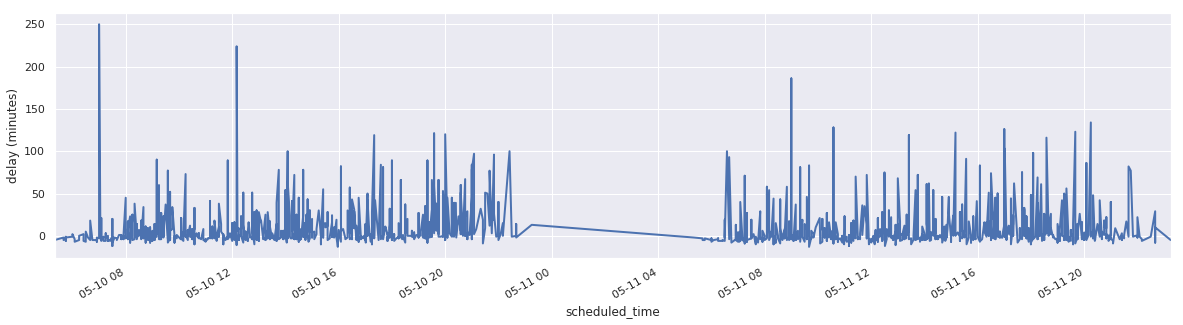

In [19]:
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(20, 5)})
ax = dfw['delay'].plot(linewidth=2);
ax.set_ylabel('delay (minutes)');

We can train & predict on batch using Pandas using the .rolling() method

In [15]:
def is_anomaly(xarr):
    outcome = xarr[-1] # the last item
    
    # discard min & max value & current (last) item
    xarr = xarr.drop(index=[xarr.idxmin(), xarr.idxmax(), xarr.index[-1]])
    if len(xarr) < 3:
        # need at least three items to compute a valid standard deviation
        return False
    
    # Fit a model (4-sigma deviations)
    prediction = xarr.mean()
    acceptable_deviation = 4 * xarr.std()
    return np.abs(outcome - prediction) > acceptable_deviation

PERIOD = '2h'
windowed = dfw.copy()
windowed['anomaly'] = dfw['delay'].rolling(PERIOD).apply(is_anomaly, raw=False).astype('bool')
windowed.head()

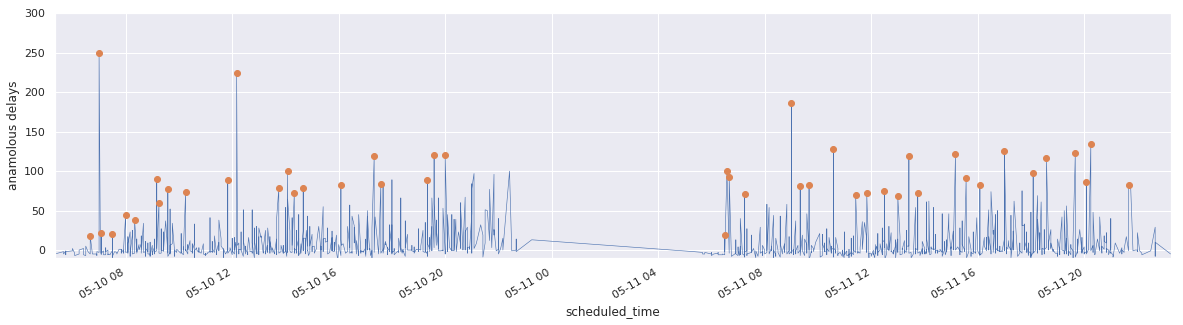

In [21]:
windowed['delay'].plot(linewidth=0.6);
anomalies = windowed[windowed['anomaly']]
ax = anomalies['delay'].plot(linewidth=2.0, style='o');
ax.set_ylabel('anamolous delays');
ax.set_ylim([-10, 300]);

## Stateful pipeline using Beam

In order to be able to do this in real-time, we can use Apache Beam.
This will allow us to have a stateful pipeline.
We demonstrate using the interactive runner (which works in notebooks)

In [23]:
dfw.to_csv('delays.csv', header=False)

In [24]:
!head delays.csv

2010-05-10 05:20:00,-5.0
2010-05-10 05:40:00,-2.0
2010-05-10 05:40:00,-5.0
2010-05-10 05:45:00,-1.0
2010-05-10 05:45:00,-6.0
2010-05-10 05:45:00,-2.0
2010-05-10 06:00:00,-1.0
2010-05-10 06:00:00,-1.0
2010-05-10 06:00:00,2.0
2010-05-10 06:05:00,-4.0


In [53]:
import apache_beam as beam
from apache_beam.runners.interactive import interactive_runner
import apache_beam.runners.interactive.interactive_beam as ib
import datetime

def parse_line(line):
    import datetime
    timestamp, delay = line.split(",")
    timestamp = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    return beam.window.TimestampedValue(
        {
            'scheduled': timestamp,
            'delay': float(delay)
        },
        timestamp.timestamp() # unix timestamp
    )

p = beam.Pipeline(interactive_runner.InteractiveRunner())
data = (p 
        | 'files' >> beam.io.ReadFromText('delays.csv')
        | 'parse' >> beam.Map(parse_line))

ib.show(data)

In [54]:
## Time window into 2 hour windows, triggered at the arrival of every new point

windowed = (data
            | 'window' >> beam.WindowInto(
                beam.window.FixedWindows(2*60*60),
                trigger=beam.trigger.AfterCount(1), # every element
                accumulation_mode=beam.trigger.AccumulationMode.ACCUMULATING))
ib.show(windowed, include_window_info=True)

In [79]:
# Carry out anomaly detection on windowed stream.
# The is_anomaly() function is called with time-sorted Series of delay values
import pandas as pd
import numpy as np
    
def is_anomaly(orig):
    outcome = orig[-1] # the last item

    # discard min & max value & current (last) item
    xarr = np.delete(orig, [np.argmin(orig), np.argmax(orig), len(orig)-1])
    if len(xarr) < 3:
        # need at least three items to compute a valid standard deviation
        return False

    # Fit a model (4-sigma deviations)
    prediction = np.mean(xarr)
    acceptable_deviation = 4 * np.std(xarr)
    result = np.abs(outcome - prediction) > acceptable_deviation
    if result:
        # anomaly
        print(orig)
    return result

class AnomalyFn(beam.CombineFn):
    def create_accumulator(self):
        return pd.DataFrame()

    def add_input(self, dfw, window):
        return dfw.append(window, ignore_index=True)

    def merge_accumulators(self, dfs):
        return pd.concat(dfs)

    def extract_output(self, dfw):
        if len(dfw) < 1:
            return None
        dfw = dfw.sort_values(by='scheduled').reset_index(drop=True);
        last_row = {}
        for col in dfw.columns:
            last_row[col] = dfw[col].iloc[len(dfw)-1]
        last_row['is_anomaly'] = is_anomaly(dfw['delay'].values)
        if last_row['is_anomaly']:
            print(last_row)
        return last_row

anomalies = windowed | 'find_anomaly' >> beam.transforms.CombineGlobally(AnomalyFn()).without_defaults()
ib.show(anomalies, include_window_info=False)

## Run as pipeline

We can the ReadFromText() and WriteToText() to read/write to Pub/Sub to get a stateful real-time pipeline

In [83]:
!rm -f anom*json*
%run ./find_anomalies.py

In [88]:
!wc -l delays.csv
!cat anom*json*

1487 delays.csv
{'delay': -2.0, 'scheduled': Timestamp('2010-05-10 05:45:00'), 'is_anomaly': False}
{'delay': 0.0, 'scheduled': Timestamp('2010-05-10 07:55:00'), 'is_anomaly': False}
{'delay': 1.0, 'scheduled': Timestamp('2010-05-10 09:55:00'), 'is_anomaly': False}
{'delay': 3.0, 'scheduled': Timestamp('2010-05-10 11:55:00'), 'is_anomaly': False}
{'delay': -4.0, 'scheduled': Timestamp('2010-05-10 13:55:00'), 'is_anomaly': False}
{'delay': -13.0, 'scheduled': Timestamp('2010-05-10 15:58:00'), 'is_anomaly': False}
{'delay': 10.0, 'scheduled': Timestamp('2010-05-10 17:55:00'), 'is_anomaly': False}
{'delay': 53.0, 'scheduled': Timestamp('2010-05-10 19:55:00'), 'is_anomaly': False}
{'delay': -1.0, 'scheduled': Timestamp('2010-05-10 21:55:00'), 'is_anomaly': False}
{'delay': 13.0, 'scheduled': Timestamp('2010-05-10 23:15:00'), 'is_anomaly': False}
{'delay': -3.0, 'scheduled': Timestamp('2010-05-11 05:45:00'), 'is_anomaly': False}
{'delay': 6.0, 'scheduled': Timestamp('2010-05-11 07:55:00'), 

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License